# Exploratory Data Analysis

## 1. Personal Information
Name: Rosa Keuss

Student ID: 12690589

E-mail address: rosa.keuss@student.uva.nl

Submitted on: 18-03-2025

Github repository: https://github.com/rkeuss/toxic-cloud-segmentation

## 2. Data Context
In this study, both video-labeled data and pixel-labeled data is used.

IJmond (Video-Labeled)
To include local data, the IJmond (https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/main/dataset/2024-01-22) video dataset (IJmond-VID) is used. IJmond-VID has a limited size as it consists of 879 video clips. These clips originate from three camera angles of the Tata Steel site.

IJmond (Pixel-Labeled)
The video frames of the IJmond dataset discussed were manually annotated on pixel-level in RoboFlo2, an online tool facilitating image annotation. Therefore, around 900 segmented video frames are available. Additionally, the IJmond video frames discussed previously were cropped and these cropped images were segmented resulting in another pixel-level dataset of about 900 images. These two datasets will be combined and hereafter they will be called 'IJmond-SEG'.

## 3. Data Description

### Imports

This cell imports the necessary libraries and modules for our analysis. It includes data manipulation tools such as Pandas and NumPy, visualization libraries like Matplotlib.

In [8]:
import os
import json
import pandas as pd
import cv2
import glob
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
# import segmentation_models_pytorch as smp
from sklearn.metrics import jaccard_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import Counter
from tqdm import tqdm
from IPython.display import Markdown
from pycocotools.coco import COCO
import coco_dataset
import ssl

/Users/rkeuss/PycharmProjects/toxic-cloud-segmentation/.venv/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Load data

#### IJMOND-VID
In this section, notice that the algorithm used to pick one frame from each video does not always pick the good frame. The frame may not contain smoke (but the video contains smoke). Data cleaning is needed to exclude those frames not containing any smoke.


In [2]:
base_path = "data/dataset/IJMOND_VID"
image_files = []

for root, dirs, files in os.walk(base_path):
    # Check if the current directory is a frame directory (numeric folder name)
    if os.path.basename(root).isdigit():
        for file in files:
            if file.endswith(".png"):
                image_files.append(os.path.join(root, file))

                                          image_path
0  data/dataset/IJMOND_VID/bbox_batch_2/B6goTCxdT...
1  data/dataset/IJMOND_VID/bbox_batch_2/B6goTCxdT...
2  data/dataset/IJMOND_VID/bbox_batch_2/cXROio3tc...
3  data/dataset/IJMOND_VID/bbox_batch_2/cXROio3tc...
4  data/dataset/IJMOND_VID/bbox_batch_2/9srWEqkUa...
5  data/dataset/IJMOND_VID/bbox_batch_2/9srWEqkUa...
6  data/dataset/IJMOND_VID/bbox_batch_2/XufZFo45V...
7  data/dataset/IJMOND_VID/bbox_batch_2/XufZFo45V...
8  data/dataset/IJMOND_VID/bbox_batch_2/wDEDMiQes...
9  data/dataset/IJMOND_VID/bbox_batch_2/wDEDMiQes...


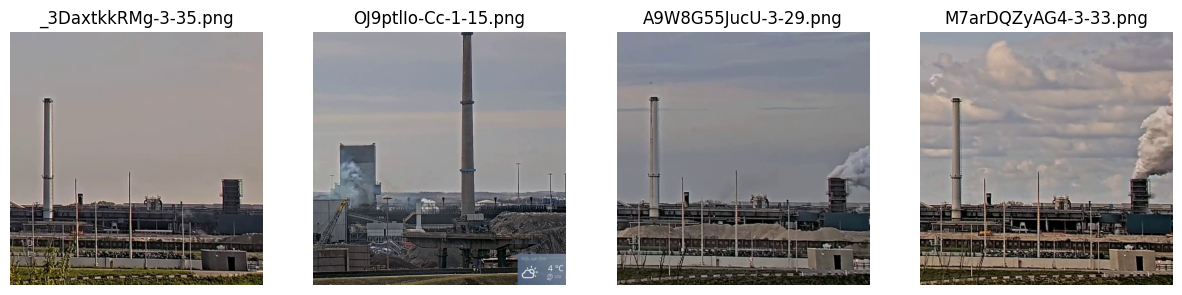

In [3]:
# Create a DataFrame
df = pd.DataFrame(image_files, columns=["image_path"])

# Display first few paths as text
print(df.head(10))  # Print first 10 paths

# Function to display images
def show_images(image_list, num_images=4):
    sample_images = random.sample(image_list, min(num_images, len(image_list)))  # Select random images
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

    for i, img_path in enumerate(sample_images):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(img_path))

    plt.show()

# Show a few images from the dataset
show_images(image_files)

In [4]:
# Lists to store extracted data
n_ijmond_img_images = len(image_files)
n_ijmond_img_boxes = len(image_files)
n_ijmond_img_categ = 1
ijmond_img_heights = []   # Image heights
ijmond_img_widths = []    # Image widths

for img_path in image_files:
    image = cv2.imread(img_path)
    if image is not None:
        h, w, _ = image.shape
        ijmond_img_heights.append(h)
        ijmond_img_widths.append(w)
    else:
        ijmond_img_heights.append(None)
        ijmond_img_widths.append(None)

Let's look at the spatial distribution of object annotations across images.

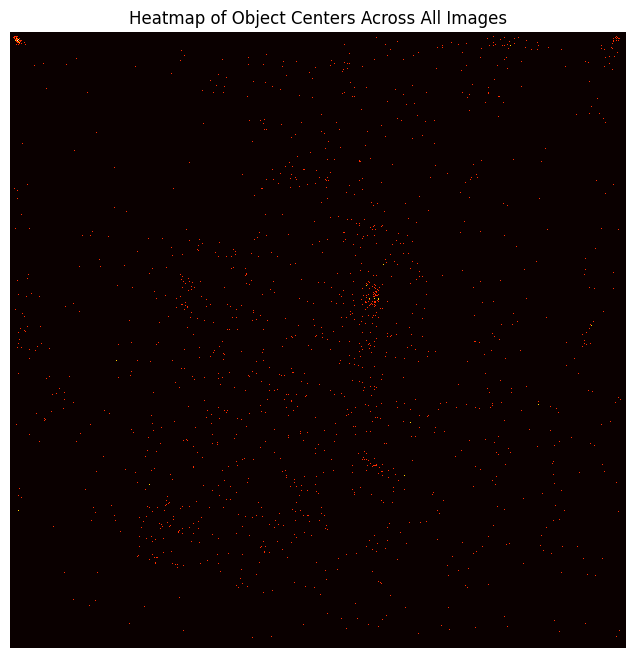

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Define the base path of the dataset
base_path = "data/dataset/IJMOND_VID"

# Initialize heatmap
heatmap_data = np.zeros((640, 640))

# Traverse dataset to find metadata.json files
for root, dirs, files in os.walk(base_path):
    if "metadata.json" in files:
        metadata_path = os.path.join(root, "metadata.json")

        # Load metadata.json
        with open(metadata_path, "r") as f:
            metadata = json.load(f)

        # Extract bounding box and image size information
        bbox = metadata["boxes"]
        img_width = metadata["image_width"]
        img_height = metadata["image_height"]

        # Compute the center of the bounding box
        center_x = int((bbox["x"] + bbox["w"] / 2) * (640 / img_width))
        center_y = int((bbox["y"] + bbox["h"] / 2) * (640 / img_height))

        # Ensure coordinates are within bounds
        center_x = max(0, min(639, center_x))
        center_y = max(0, min(639, center_y))

        # Update heatmap
        heatmap_data[center_y, center_x] += 1

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(heatmap_data), cmap='hot', interpolation='nearest')  # Log scale for visibility
plt.axis('off')
plt.title('Heatmap of Object Centers Across All Images')
plt.show()

#### RISE

In [6]:
import requests
import os
import json
import cv2

metadata_file_path = 'data/RISE/metadata.json'
output_dir = 'data/RISE/extracted_frames/'

os.makedirs(output_dir, exist_ok=True)

with open(metadata_file_path, 'r') as f:
    metadata = json.load(f)

positive_videos = [
    video for video in metadata
    if video['label_state'] in [47, 23] or video['label_state_admin'] in [47, 23]
]

def download_video(url_root, url_part, save_path):
    video_url = url_root + url_part
    response = requests.get(video_url, stream=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

def extract_frame(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return frame
    else:
        print(f"Failed to read frame {frame_number} from {video_path}")
        return None

for video in positive_videos:
    file_name = video['file_name']
    url_root = video['url_root'].replace('/180/', '/320/')
    url_part = video['url_part'].replace('-180-180-', '-320-320-')

    # Determine the full path to save the video
    video_file_path = os.path.join(output_dir, f"{file_name}.mp4")

    # Download the video (if not already downloaded)
    if not os.path.exists(video_file_path):
        download_video(url_root, url_part, video_file_path)

    frame = extract_frame(video_file_path, frame_number=0)
    if frame is not None:
        frame_file_path = os.path.join(output_dir, f"{file_name}_frame.png")
        cv2.imwrite(frame_file_path, frame)

print("Frame extraction completed.")

KeyboardInterrupt: 

#### IJMOND-SEG

Let's first load the data and look at the general structure.

In [9]:
import json
json_path = "../data/IJMOND_SEG/_annotations.coco.json"
with open(json_path, "r") as f:
    coco_data = json.load(f)

coco = COCO(json_path)
imgIds = coco.getImgIds()
images = coco.loadImgs(imgIds)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [10]:
print("IJMOND-SEG Keys: ", coco_data.keys())
print("Dataset Info:", coco_data["info"])
print("Categories:", coco_data["categories"])
print("Total Images:", len(coco_data["images"]))
print("Images Keys: ", coco_data['images'][0].keys())
print("Total Annotations:", len(coco_data["annotations"]))
print("Licences Keys: ", coco_data['licenses'][0].keys())

# Count occurrences of "hoogovens" vs "kooks"
image_filenames = [img["file_name"] for img in coco_data["images"]]
category_counts = Counter(["hoogovens" if "hoogovens" in fname else "kooks" for fname in image_filenames])
print(f"Dataset Split: {category_counts}")

n_ijmond_seg_images = len(coco_data['images'])
n_ijmond_seg_boxes = len(coco_data['annotations'])
n_ijmond_seg_categ = len(coco_data['categories'])
ijmond_seg_heights = [x['height'] for x in coco_data['images']]
ijmond_seg_widths = [x['width'] for x in coco_data['images']]

IJMOND-SEG Keys:  dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
Dataset Info: {'year': '2025', 'version': '5', 'description': 'Exported from roboflow.com', 'contributor': '', 'url': 'https://public.roboflow.com/object-detection/undefined', 'date_created': '2025-02-13T22:21:42+00:00'}
Categories: [{'id': 0, 'name': 'smoke', 'supercategory': 'none'}, {'id': 1, 'name': 'high-opacity-smoke', 'supercategory': 'smoke'}, {'id': 2, 'name': 'low-opacity-smoke', 'supercategory': 'smoke'}]
Total Images: 900
Images Keys:  dict_keys(['id', 'license', 'file_name', 'height', 'width', 'date_captured'])
Total Annotations: 1209
Licences Keys:  dict_keys(['id', 'url', 'name'])
Dataset Split: Counter({'kooks': 891, 'hoogovens': 9})


So the pixels are labeled as 'background' or 'smoke'. If a pixel has label 'smoke' a distinction is made between 'high opacity smoke' and 'low-opacity-smoke'. Furthermore, the total number of annotations is 1209.

Now, we will look at the spatial distribution of object annotations across images.

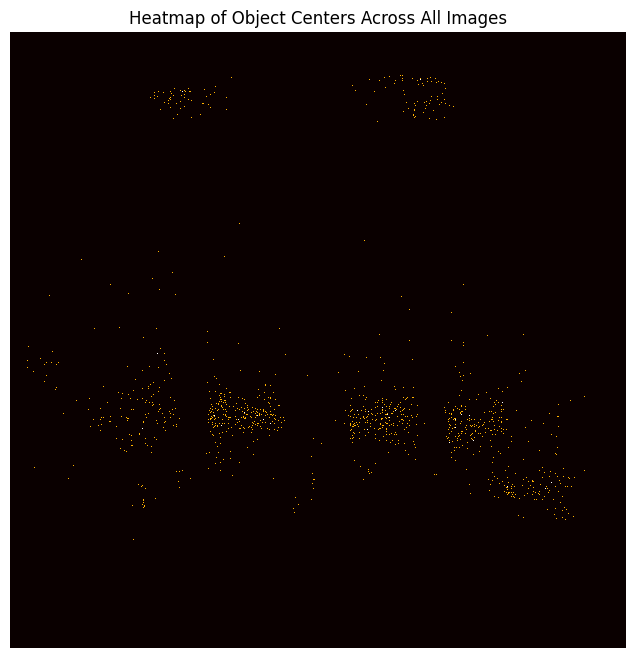

In [13]:
import numpy as np
import matplotlib.pyplot as plt
heatmap_data = np.zeros((640, 640))
for img_id in imgIds:
    img = coco.loadImgs(img_id)[0]
    annIds = coco.getAnnIds(imgIds=img['id'])
    anns = coco.loadAnns(annIds)
    for ann in anns:
        # Normalize x and y to the heatmap resolution
        bbox = ann['bbox']
        center_x = int((bbox[0] + bbox[2] / 2) * (640 / img['width']))
        center_y = int((bbox[1] + bbox[3] / 2) * (640 / img['height']))
        heatmap_data[center_y, center_x] += 1

plt.figure(figsize=(8, 8))
plt.imshow(np.log1p(heatmap_data), cmap='hot', interpolation='nearest') # Use log scale for better visibility
plt.axis('off')
plt.title('Heatmap of Object Centers Across All Images')
plt.show()

There are roughly 6 'heat islands' visable. This means most centers of smoke are located around one of those. This is ofcourse logical as the steal factories are not moving objects.

Next, example visualizations from the dataset are given.

{'kooks': {'high-opacity-smoke': {'id': 0, 'license': 1, 'file_name': 'kooks_2__2024-08-28T10-06-56Z_frame_1743_jpg.rf.d5bc6a3501d35a7ceca12f62950a968b.jpg', 'height': 1080, 'width': 1920, 'date_captured': '2025-02-13T22:21:42+00:00'}, 'low-opacity-smoke': {'id': 0, 'license': 1, 'file_name': 'kooks_2__2024-08-28T10-06-56Z_frame_1743_jpg.rf.d5bc6a3501d35a7ceca12f62950a968b.jpg', 'height': 1080, 'width': 1920, 'date_captured': '2025-02-13T22:21:42+00:00'}}, 'hoogovens': {'high-opacity-smoke': {'id': 5, 'license': 1, 'file_name': 'hoogovens_6_7__2024-11-06T12-42-10Z_frame_1320_jpg.rf.dcc0d4cbef048f0f4e9c69aa0c449fb0.jpg', 'height': 1080, 'width': 1920, 'date_captured': '2025-02-13T22:21:42+00:00'}, 'low-opacity-smoke': {'id': 270, 'license': 1, 'file_name': 'hoogovens_6_7__2024-11-12T13-44-03Z_frame_3554_jpg.rf.ad302369206412d669f75e0eb3eaf75e.jpg', 'height': 1080, 'width': 1920, 'date_captured': '2025-02-13T22:21:42+00:00'}}}


[ WARN:0@52.681] global loadsave.cpp:268 findDecoder imread_('data/dataset/IJMOND_SEG/test/kooks_2__2024-08-28T10-06-56Z_frame_1743_jpg.rf.d5bc6a3501d35a7ceca12f62950a968b.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


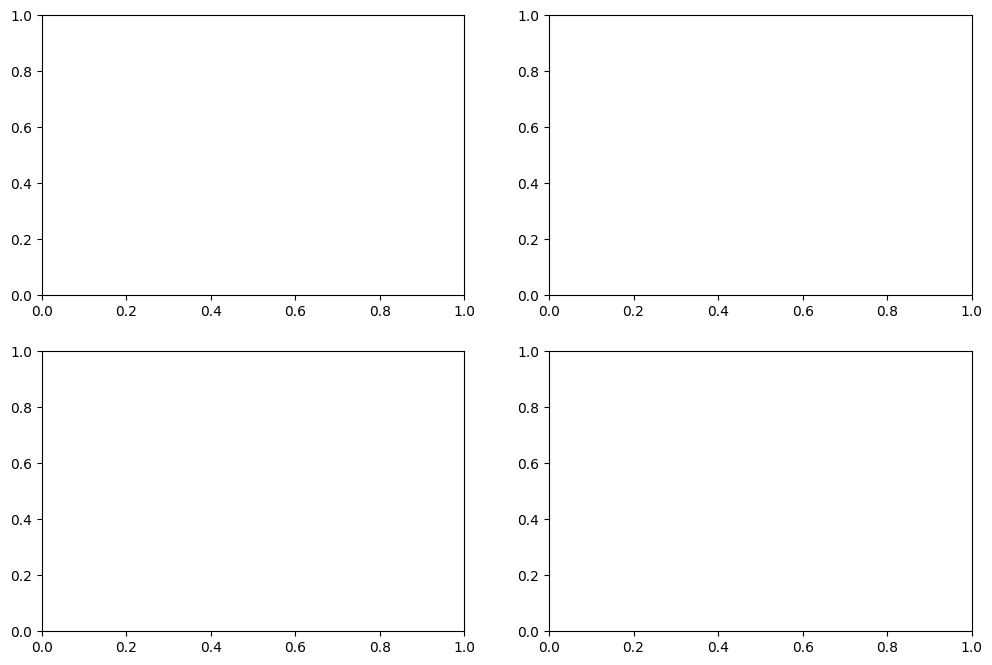

In [14]:
# Organize images by category ('kooks' or 'hoogovens') and smoke type
selected_images = {
    "kooks": {"high-opacity-smoke": None, "low-opacity-smoke": None},
    "hoogovens": {"high-opacity-smoke": None, "low-opacity-smoke": None}
}

# Find suitable images
for img in images:
    img_id = img["id"]
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id))

    # Determine category (kooks or hoogovens)
    category = "hoogovens" if "hoogovens" in img["file_name"] else "kooks"

    # Check for smoke types
    smoke_types = {ann["category_id"]: ann for ann in anns}
    if 1 in smoke_types and selected_images[category]["high-opacity-smoke"] is None:
        selected_images[category]["high-opacity-smoke"] = img
    if 2 in smoke_types and selected_images[category]["low-opacity-smoke"] is None:
        selected_images[category]["low-opacity-smoke"] = img

    # Stop if we found all required images
    if all(v is not None for v in selected_images["kooks"].values()) and \
       all(v is not None for v in selected_images["hoogovens"].values()):
        print(selected_images)
        break

# Function to draw bounding boxes and segmentation masks
def draw_annotations(image_path, anns):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for ann in anns:
        x, y, w, h = ann["bbox"]
        cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (255, 0, 0), 2)

        for seg in ann["segmentation"]:
            seg = np.array(seg, dtype=np.int32).reshape((-1, 2))
            cv2.polylines(image, [seg], isClosed=True, color=(0, 255, 0), thickness=2)

    return image

# Display selected images
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
titles = ["Kooks - High Opacity", "Kooks - Low Opacity", "Hoogovens - High Opacity", "Hoogovens - Low Opacity"]

for i, (category, smoke_dict) in enumerate(selected_images.items()):
    for j, (smoke_type, img) in enumerate(smoke_dict.items()):
        if img is not None:
            image_path = f"data/dataset/IJMOND_SEG/test/{img['file_name']}"
            anns = coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
            image = draw_annotations(image_path, anns)
            axes[i * 2 + j].imshow(image)
            axes[i * 2 + j].set_title(titles[i * 2 + j])
            axes[i * 2 + j].axis("off")

plt.tight_layout()
plt.show()

Lastly, let's compare IJmond-VID to IJmond-SEG.

In [10]:
data = [
    {
        "Split": "IJmond-VID",
        "Number of images": n_ijmond_img_images,
        "Number of bounding boxes": n_ijmond_img_boxes,
        "Number of classes": n_ijmond_img_categ,
        "Height-Max": max(ijmond_img_heights),
        "Height-Min": min(ijmond_img_heights),
        "Height-Avg": int(sum(ijmond_img_heights) / len(ijmond_img_heights)),
        "Width-Max": max(ijmond_img_widths),
        "Width-Min": min(ijmond_img_widths),
        "Width-Avg": int(sum(ijmond_img_widths) / len(ijmond_img_widths))
    },
    {
        "Split": "IJmond-SEG",
        "Number of images": n_ijmond_seg_images,
        "Number of bounding boxes": n_ijmond_seg_boxes,
        "Number of classes": n_ijmond_seg_categ,
        "Height-Max": max(ijmond_seg_heights),
        "Height-Min": min(ijmond_seg_heights),
        "Height-Avg": int(sum(ijmond_seg_heights) / len(ijmond_seg_heights)),
        "Width-Max": max(ijmond_seg_widths),
        "Width-Min": min(ijmond_seg_widths),
        "Width-Avg": int(sum(ijmond_seg_widths) / len(ijmond_seg_widths))
    }
]

markdown_table = "|| Split | Number of images | Number of bounding boxes | Number of classes | Height Max | Height Min | Height Avg | Width Max | Width Min | Width Avg |\n"
markdown_table += "|---|---|---|---|---|---|---|---|---|---|---|\n"
for i, row in enumerate(data, start=1):
    markdown_table += (f"| {i} | {row['Split']} | {row['Number of images']} | "
                       f"{row['Number of bounding boxes']} | {row['Number of classes']} |"
                       f"{row['Height-Max']} | {row['Height-Min']} | {row['Height-Avg']} |"
                       f"{row['Width-Max']} | {row['Width-Min']} | {row['Width-Avg']} |\n")

display(Markdown(markdown_table))

|| Split | Number of images | Number of bounding boxes | Number of classes | Height Max | Height Min | Height Avg | Width Max | Width Min | Width Avg |
|---|---|---|---|---|---|---|---|---|---|---|
| 1 | IJmond-VID | 940 | 940 | 1 |900 | 600 | 720 |900 | 600 | 720 |
| 2 | IJmond-SEG | 900 | 1209 | 3 |1080 | 1080 | 1080 |1920 | 1920 | 1920 |


In [10]:
# Import necessary libraries
import os
import json
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import numpy as np

# Path to the COCO annotations file
annotations_path = "../data/IJMOND_SEG/cropped/cropped_annotations.json"

# Load the COCO dataset
with open(annotations_path, "r") as f:
    coco_data = json.load(f)

coco = COCO(annotations_path)
img_ids = coco.getImgIds()
images = coco.loadImgs(img_ids)

# Function to visualize ground truth masks
def visualize_ground_truth_masks(image_id, coco, base_path="../data/IJMOND_SEG/cropped/"):
    # Validate if the image_id exists in the dataset
    if image_id not in coco.getImgIds():
        raise ValueError(f"Image ID {image_id} does not exist in the dataset.")

    # Load image metadata
    img_info = coco.loadImgs(image_id)
    if not img_info:
        raise ValueError(f"Image ID {image_id} could not be loaded.")

    img_info = img_info[0]
    img_path = os.path.join(base_path, img_info["file_name"])

    # Load the image
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file {img_path} does not exist.")

    # Load the image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create an empty mask
    mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)

    # Load annotations for the image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # Combine all segmentations into a single mask
    for ann in anns:
        for seg in ann["segmentation"]:
            seg = np.array(seg, dtype=np.int32).reshape((-1, 2))
            cv2.fillPoly(mask, [seg], color=255)

    # Display the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Visualize a few random masks
for i in range(5):  # Adjust the number of visualizations as needed
    random_image_id = np.random.choice(img_ids)
    print("Available image IDs:", coco.getImgIds())  # Print all valid image IDs
    print("Randomly selected image ID:", random_image_id)  # Print the selected image ID
    if random_image_id not in coco.getImgIds():
        raise ValueError(f"Image ID {random_image_id} does not exist in the dataset.")
    visualize_ground_truth_masks(random_image_id, coco)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Available image IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 

ValueError: Image ID 481 could not be loaded.

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


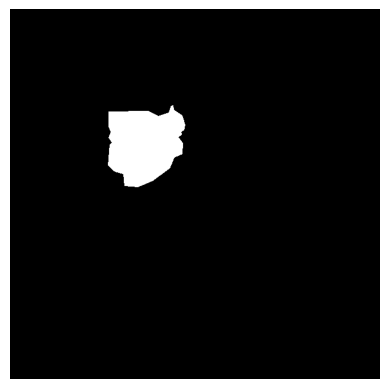

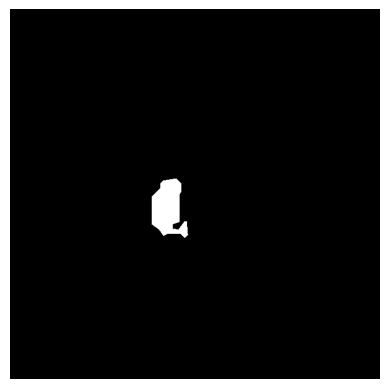

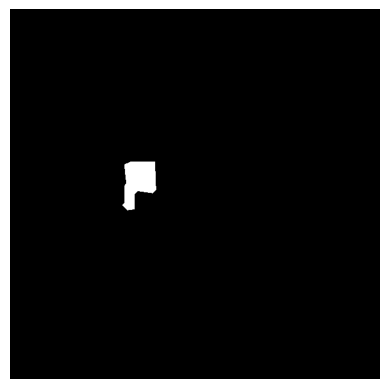

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# Load the COCO dataset
coco = COCO('/Users/rkeuss/PycharmProjects/toxic-cloud-segmentation/data/IJMOND_SEG/cropped/cropped_annotations.json')

ids = [1, 500, 900] #[19, 222, 404, 1170]
for annotation_id in ids:
    annotation = coco.loadAnns(annotation_id)[0]

    # Decode the segmentation mask
    segmentation = annotation['segmentation']
    image_id = annotation['image_id']
    image_info = coco.loadImgs(image_id)[0]

    # Create a blank mask
    height, width = image_info['height'], image_info['width']
    mask = np.zeros((height, width), dtype=np.uint8)

    # If the segmentation is a polygon, draw it
    if isinstance(segmentation, list):
        for seg in segmentation:
            rle = maskUtils.frPyObjects([seg], height, width)
            mask += maskUtils.decode(rle).squeeze()

    # Visualize the mask
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

## 4. Backup dataset (SMOKE5K)
The SMOKE5K dataset consists of both synthetic images and real images. It contains 5,400 images, where 400 real smoke images from it is used for testing, and the remaining 5,000 images are for training. The dataset is thus already split into a test and train set. Each set consists of the folders 'gt_' and 'img' containing the annotations and images respectively. The files in the 'gt_' folders are named like '1234567890_+12345.png'. The same holds for the images, but they are in .jpg format. Below, both the train and test set will be loaded and some examples will be shown. However, as this is a backup dataset, it will not be analyzed as extensively as the IJmond data.

In [27]:
train_img_dir = "data/dataset/SMOKE5K/train/img"
train_gt_dir = "data/dataset/SMOKE5K/train/gt"
test_img_dir = "data/dataset/SMOKE5K/test/img"
test_gt_dir = "data/dataset/SMOKE5K/test/gt_"

train_images = sorted(glob.glob(os.path.join(train_img_dir, "*.jpg")))
train_gt = sorted(glob.glob(os.path.join(train_gt_dir, "*.png")))

test_images = sorted(glob.glob(os.path.join(test_img_dir, "*.jpg")))
test_gt = sorted(glob.glob(os.path.join(test_gt_dir, "*.png")))

print(f"Train Images: {len(train_images)}, Train GT: {len(train_gt)}")
print(f"Test Images: {len(test_images)}, Test GT: {len(test_gt)}")

# Ensure matching filenames
for img_path, gt_path in zip(train_images[:5], train_gt[:5]):  # Checking first 5 pairs
    print("Image:", os.path.basename(img_path), "-> GT:", os.path.basename(gt_path))

Train Images: 5058, Train GT: 5058
Test Images: 400, Test GT: 400
Image: 1528757586_+00180.jpg -> GT: 1528757586_+00180.png
Image: 1528757766_+00360.jpg -> GT: 1528757766_+00360.png
Image: 1528757946_+00540.jpg -> GT: 1528757946_+00540.png
Image: 1528758306_+00900.jpg -> GT: 1528758306_+00900.png
Image: 1528758486_+01080.jpg -> GT: 1528758486_+01080.png


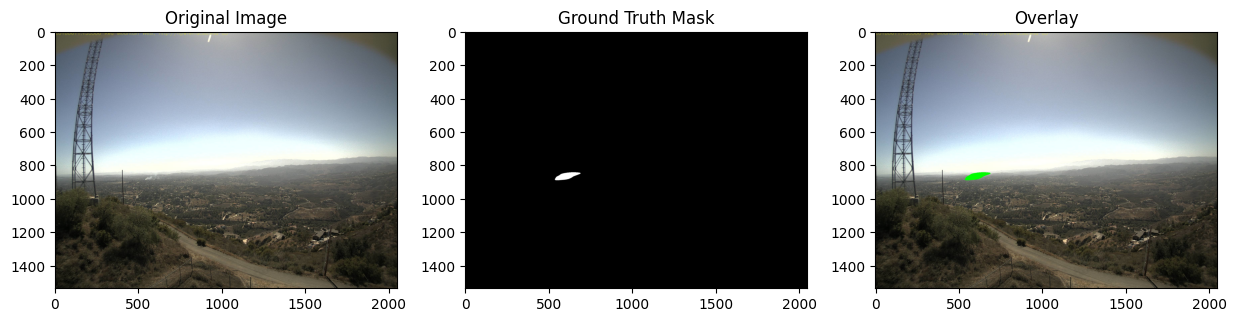

In [28]:
def show_sample(image_path, gt_path):
    # Load image and ground truth mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    gt_mask = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale

    # Resize GT mask to match image (if needed)
    if gt_mask.shape != image.shape[:2]:
        gt_mask = cv2.resize(gt_mask, (image.shape[1], image.shape[0]))

    # Create overlay (green mask)
    overlay = image.copy()
    overlay[gt_mask > 0] = (0, 255, 0)

    # Display images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(gt_mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay")
    plt.show()

# Show an example
show_sample(train_images[0], train_gt[0])


To convert the SMOKE5K dataset to COCO format, the following code should be executed. Conversion to COCO format allows usage with standard ML frameworks.

In [31]:
coco_data_5k = {
    "images": [],
    "annotations": [],
    "categories": [{"id": 0, "name": "smoke", "supercategory": "none"}]
}

def get_image_size(image_path):
    """Returns (height, width) of an image"""
    image = cv2.imread(image_path)  # Read image
    if image is None:
        return None  # Skip if the image is missing or unreadable
    height, width = image.shape[:2]  # Extract dimensions
    return height, width

def get_bbox(mask_path):
    """Computes bounding box from binary mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None  # Skip if mask is missing

    # Find all non-zero pixels
    ys, xs = np.where(mask > 0)

    # Compute bounding box (x, y, width, height)
    if len(xs) > 0 and len(ys) > 0:
        x_min, y_min = xs.min(), ys.min()
        x_max, y_max = xs.max(), ys.max()
        w, h = x_max - x_min, y_max - y_min
        return [int(x_min), int(y_min), int(w), int(h)]
    return None  # Return None if no mask is found


def get_segmentation(mask_path):
    """Computes segmentation polygons from binary mask"""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return []  # Return empty if no mask

    # Find contours (external only)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        # Flatten contour coordinates into a single list
        segmentation.append(contour.flatten().tolist())

    return segmentation


# Iterate over images and masks
for idx, (img_path, gt_path) in enumerate(zip(train_images, train_gt)):
    file_name = os.path.basename(img_path)

    height, width = get_image_size(img_path)
    bbox = get_bbox(gt_path)

    coco_data_5k["images"].append({
        "id": idx,
        "file_name": file_name,
        "height": height,
        "width": width
    })

    coco_data_5k["annotations"].append({
        "id": idx,
        "image_id": idx,
        "category_id": 0,
        "bbox": bbox,
        "segmentation": get_segmentation(gt_path),
        "iscrowd": 0,
        "area": bbox[2] * bbox[3]
    })


# Save as JSON
with open("data/dataset/SMOKE5K/smoke5k_coco.json", "w") as f:
    json.dump(coco_data_5k, f)

print("COCO Dataset Created!")

COCO Dataset Created!


## 5. Baseline model

Implementation using DeepLabV3+ with ResNet50 as a backbone, which is a common and strong baseline. For now, I switched to FPN MobilenetV2 to make it much lighter and faster.

In [9]:
# Load Pretrained DeepLabV3+ Model

ssl._create_default_https_context = ssl._create_unverified_context
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smp.FPN(
    encoder_name="mobilenet_v2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=4
).to(device)


In [10]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define Training and Validation Loops
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(loader):
        print(f"🟢 Training batch {batch_idx+1}/{len(loader)}")  # ✅ Debug print

        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            running_loss += loss.item()

    return running_loss / len(loader)

In [11]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [12]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)  # Ensure spawn method is used

    # Define path
    coco_annotations = "data/dataset/IJMOND_SEG/test/_annotations.coco.json"
    coco_images = "data/dataset/IJMOND_SEG/test/"

    # Load COCO dataset
    coco = COCO(coco_annotations)
    imgIds = coco.getImgIds()

    # Split dataset
    train_size = int(0.8 * len(imgIds))
    train_imgIds = imgIds[:train_size]
    val_imgIds = imgIds[train_size:]

    # Define dataset
    train_dataset = coco_dataset.COCOSegmentationDataset(coco, train_imgIds, coco_images, transform=train_transform)
    val_dataset = coco_dataset.COCOSegmentationDataset(coco, val_imgIds, coco_images, transform=val_transform)

    # Define data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

    num_epochs = 25
    best_loss = float("inf")
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = validate(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")

        scheduler.step()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Trai

100%|██████████| 23/23 [00:09<00:00,  2.37it/s]


Epoch [1/25], Train Loss: 0.0519, Val Loss: 0.0232
Model saved!
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 

100%|██████████| 23/23 [00:09<00:00,  2.41it/s]


Epoch [2/25], Train Loss: 0.0221, Val Loss: 0.0167
Model saved!
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 

100%|██████████| 23/23 [00:09<00:00,  2.39it/s]


Epoch [3/25], Train Loss: 0.0178, Val Loss: 0.0154
Model saved!
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 

100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


Epoch [4/25], Train Loss: 0.0154, Val Loss: 0.0130
Model saved!
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 

100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


Epoch [5/25], Train Loss: 0.0139, Val Loss: 0.0142
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training batc

100%|██████████| 23/23 [00:12<00:00,  1.83it/s]


Epoch [6/25], Train Loss: 0.0130, Val Loss: 0.0142
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training batc

100%|██████████| 23/23 [00:09<00:00,  2.36it/s]


Epoch [7/25], Train Loss: 0.0119, Val Loss: 0.0137
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training batc

100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Epoch [8/25], Train Loss: 0.0108, Val Loss: 0.0136
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training batc

100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch [9/25], Train Loss: 0.0101, Val Loss: 0.0136
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training batc

100%|██████████| 23/23 [00:09<00:00,  2.38it/s]


Epoch [10/25], Train Loss: 0.0095, Val Loss: 0.0140
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.31it/s]


Epoch [11/25], Train Loss: 0.0093, Val Loss: 0.0137
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.32it/s]


Epoch [12/25], Train Loss: 0.0087, Val Loss: 0.0137
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


Epoch [13/25], Train Loss: 0.0083, Val Loss: 0.0136
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


Epoch [14/25], Train Loss: 0.0082, Val Loss: 0.0134
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.20it/s]


Epoch [15/25], Train Loss: 0.0081, Val Loss: 0.0134
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.28it/s]


Epoch [16/25], Train Loss: 0.0080, Val Loss: 0.0137
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.15it/s]


Epoch [17/25], Train Loss: 0.0080, Val Loss: 0.0135
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:11<00:00,  2.04it/s]


Epoch [18/25], Train Loss: 0.0079, Val Loss: 0.0135
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.33it/s]


Epoch [19/25], Train Loss: 0.0077, Val Loss: 0.0139
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.22it/s]


Epoch [20/25], Train Loss: 0.0076, Val Loss: 0.0136
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.30it/s]


Epoch [21/25], Train Loss: 0.0074, Val Loss: 0.0138
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.29it/s]


Epoch [22/25], Train Loss: 0.0076, Val Loss: 0.0138
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:10<00:00,  2.24it/s]


Epoch [23/25], Train Loss: 0.0076, Val Loss: 0.0138
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:09<00:00,  2.34it/s]


Epoch [24/25], Train Loss: 0.0076, Val Loss: 0.0138
🟢 Training batch 1/90
🟢 Training batch 2/90
🟢 Training batch 3/90
🟢 Training batch 4/90
🟢 Training batch 5/90
🟢 Training batch 6/90
🟢 Training batch 7/90
🟢 Training batch 8/90
🟢 Training batch 9/90
🟢 Training batch 10/90
🟢 Training batch 11/90
🟢 Training batch 12/90
🟢 Training batch 13/90
🟢 Training batch 14/90
🟢 Training batch 15/90
🟢 Training batch 16/90
🟢 Training batch 17/90
🟢 Training batch 18/90
🟢 Training batch 19/90
🟢 Training batch 20/90
🟢 Training batch 21/90
🟢 Training batch 22/90
🟢 Training batch 23/90
🟢 Training batch 24/90
🟢 Training batch 25/90
🟢 Training batch 26/90
🟢 Training batch 27/90
🟢 Training batch 28/90
🟢 Training batch 29/90
🟢 Training batch 30/90
🟢 Training batch 31/90
🟢 Training batch 32/90
🟢 Training batch 33/90
🟢 Training batch 34/90
🟢 Training batch 35/90
🟢 Training batch 36/90
🟢 Training batch 37/90
🟢 Training batch 38/90
🟢 Training batch 39/90
🟢 Training batch 40/90
🟢 Training batch 41/90
🟢 Training bat

100%|██████████| 23/23 [00:13<00:00,  1.67it/s]

Epoch [25/25], Train Loss: 0.0075, Val Loss: 0.0139


Now that the model is trained we perform inference and evaluate the model.

In [22]:
# perform inference

def predict_coco(model, coco, image_id, image_dir, transform):
    model.eval()

    # Load image
    img_info = coco.loadImgs(image_id)[0]
    img_path = os.path.join(image_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Transform
    augmented = transform(image=image)
    image = augmented["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        output = torch.argmax(output.squeeze(), dim=0).cpu().numpy()

    output_resized = cv2.resize(output, (img_info['width'], img_info['height']), interpolation=cv2.INTER_NEAREST)

    return output_resized


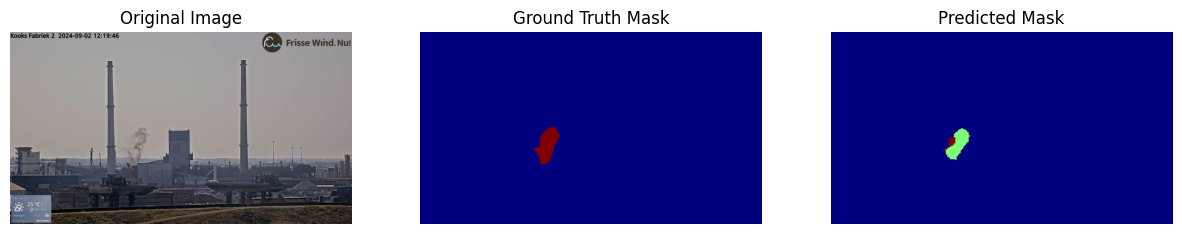

In [23]:
# Visualization of a predicted mask

import matplotlib.pyplot as plt
import numpy as np

# Example inference
image_id = val_imgIds[1]
predicted_mask = predict_coco(model, coco, image_id, coco_images, val_transform)

# Load original image
img_info = coco.loadImgs(image_id)[0]
img_path = os.path.join(coco_images, img_info['file_name'])
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load ground truth mask
ann_ids = coco.getAnnIds(imgIds=image_id)
anns = coco.loadAnns(ann_ids)
true_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

for ann in anns:
    true_mask += coco.annToMask(ann) * ann['category_id']

# Plot the image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(true_mask, cmap="jet")
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(predicted_mask, cmap="jet")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()

In [24]:
print("True mask shape:", true_mask.shape)
print("Predicted mask shape:", predicted_mask.shape)

True mask shape: (1080, 1920)
Predicted mask shape: (1080, 1920)


In [25]:
# Evaluate the model

# Flatten masks to 1D arrays
true_mask_flat = true_mask.flatten()
predicted_mask_flat = predicted_mask.flatten()

# IoU Score: IoU = (Intersection of masks) / (Union of masks). So, higher IoU (~1.0) means better segmentation quality.
iou_score = jaccard_score(true_mask_flat, predicted_mask_flat, average='macro')

# Dice Score: Higher Dice Score (~1.0) means better segmentation
dice_score = f1_score(true_mask_flat, predicted_mask_flat, average='macro')

print(f"IoU Score: {iou_score:.4f}")
print(f"Dice Score: {dice_score:.4f}")

IoU Score: 0.5579
Dice Score: 0.6019


In [26]:
# Evaluate on entire validation set

iou_scores = []
dice_scores = []

for img_id in val_imgIds[:20]:  # Evaluate on first 20 images
    predicted_mask = predict_coco(model, coco, img_id, coco_images, val_transform)

    # Load ground truth mask
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    true_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

    for ann in anns:
        true_mask += coco.annToMask(ann) * ann['category_id']

    # Compute IoU and Dice scores
    true_mask_flat = true_mask.flatten()
    predicted_mask_flat = predicted_mask.flatten()

    iou_scores.append(jaccard_score(true_mask_flat, predicted_mask_flat, average='macro'))
    dice_scores.append(f1_score(true_mask_flat, predicted_mask_flat, average='macro'))

# Print average scores
print(f"Mean IoU Score: {np.mean(iou_scores):.4f}")
print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")

Mean IoU Score: 0.5691
Mean Dice Score: 0.6099


## Conclusion
This analysis shows that both IJmond datasets can be used for my research on semantic segmentation. However, the IJmond-VID dataset still needs to be cleaned to exclude frames without smoke. Additionally, a baseline model has been already trained and evaluated using the IJmond-SEG dataset. It shows that the model does not perform good segmentation yet and could be improved significantly. In case any significant problem arises, a backup dataset is introduced.

## 7. References

IJmond dataset

1. MultiX-Amsterdam. 2024. IJmond Camera Monitor Dataset (2024-01-22). https://github.com/MultiX-Amsterdam/ijmond-camera-monitor/tree/main/dataset/2024-01-22 Accessed: 14-02-2025

SMOKE5K

2. Siyuan Yan, Jing Zhang, and Nick Barnes. 2023. Transmission-Guided Bayesian Generative Model for Smoke Segmentation. https://github.com/SiyuanYan1/Transmission-BVM/blob/main/sampling-based-BVM/data.py arXiv:2303.00900 [cs].